<a href="https://colab.research.google.com/github/dasjyotishka/Predicting-Airbnb-Prices-in-New-York-City/blob/Vanshika/Predicting_price_Airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount drive

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


#Read dataset

In [114]:
data = pd.read_csv("/content/drive/MyDrive/ensemble/project_airbnb/dataset/AB_NYC_2019.csv")
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


#Feature analysis


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [51]:
# Checking how many null values there are in each column
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

#Data Cleaning

##Removing useless columns

In [115]:
data.drop(columns=['id', 'name', 'host_id', 'host_name'],inplace=True)
data.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

##Filling in null values


In [55]:
data[data['last_review'].isnull()][['number_of_reviews','reviews_per_month']].head()

,number_of_reviews,reviews_per_month
2,0,0.0
19,0,0.0
26,0,0.0
36,0,0.0
38,0,0.0


If a certain listing has a null for its "last_review," that means it has not gotten a review at all(also proved from previous dataframe), so "reviews_per_month" must be 0. 
Also, now we can drop the last-review column containing null values from a cleaner dataset.


In [116]:
data.fillna({'reviews_per_month':0}, inplace=True)
data.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We can see that all the NA values except for the last_review column have been plugged in

#Data Visualisations

###Room type analysis

In [56]:
room_type = data.groupby('room_type').agg(avg_price=('price','mean'),
                       count=('price','count')).reset_index()
    
room_type

,room_type,avg_price,count
0,Entire home/apt,211.794246,25409
1,Private room,89.780973,22326
2,Shared room,70.127586,1160


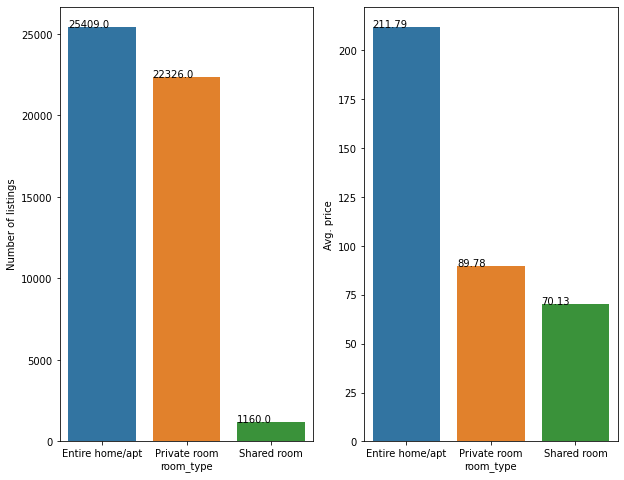

In [58]:
fig,(chart_1,chart_2) = plt.subplots(1,2,figsize=(10,8))
ax = sns.barplot(x='room_type', y = 'avg_price', data=room_type, ax=chart_2)
for p in chart_2.patches:
    chart_2.annotate("{:.2f}".format(p.get_height()),(p.get_x(),p.get_height()))
chart_2.set_ylabel("Avg. price")

ax = sns.barplot(x='room_type', y = 'count', data=room_type, ax=chart_1)
for p in chart_1.patches:
    chart_1.annotate("{:.1f}".format(p.get_height()),(p.get_x(),p.get_height()))
chart_1.set_ylabel("Number of listings")
plt.show()

We see maximum listings are either Private room or Entire home/apt

Also, Entire home/apt are most expensive.

###Neighbourhood_group(large area) analysis


In [ ]:
#Avg. price and listings per neighbourhood_group(large area)
neighbourhood_group_df = data.groupby('neighbourhood_group').agg(avg_price=('price','mean'),
                       count=('price','count')).reset_index()
    
neighbourhood_group_df

,neighbourhood_group,avg_price,count
0,Bronx,87.496792,1091
1,Brooklyn,124.383207,20104
2,Manhattan,196.875814,21661
3,Queens,99.517649,5666
4,Staten Island,114.812332,373


Text(0, 0.5, '')

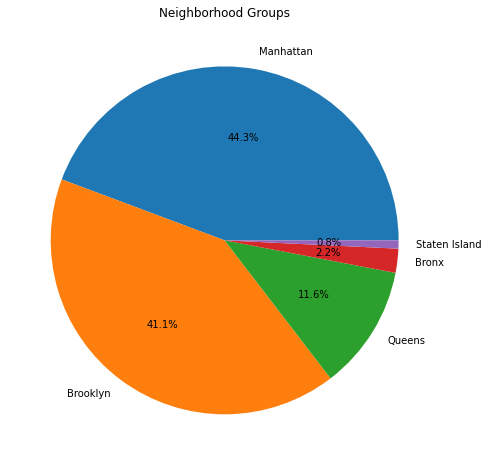

In [ ]:
#Pie chart to show listings in each neighbourhood group
pie_chart = data.neighbourhood_group.value_counts().plot.pie(title='Neighborhood Groups',
                                               figsize=(8,8),
                                              autopct='%1.1f%%')
pie_chart.set_ylabel(None)

We see that more than 85% of listings are located in Manhattan and Brooklyn.

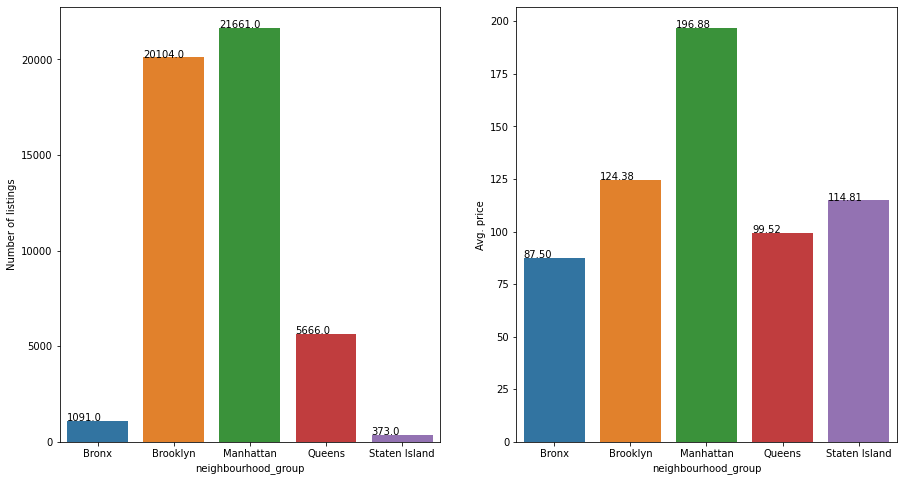

In [59]:
fig,(chart_1,chart_2) = plt.subplots(1,2,figsize=(15,8))
ax = sns.barplot(x='neighbourhood_group', y = 'avg_price', data=neighbourhood_group_df, ax=chart_2)
for p in chart_2.patches:
    chart_2.annotate("{:.2f}".format(p.get_height()),(p.get_x(),p.get_height()))
chart_2.set_ylabel("Avg. price")

ax = sns.barplot(x='neighbourhood_group', y = 'count', data=neighbourhood_group_df, ax=chart_1)
for p in chart_1.patches:
    chart_1.annotate("{:.1f}".format(p.get_height()),(p.get_x(),p.get_height()))
chart_1.set_ylabel("Number of listings")
plt.show()

We see that highest average price is of listings are located in Manhattan

###Neighbourhood Analysis

In [60]:
neighbourhood_df = data.groupby('neighbourhood').agg(avg_price=('price','mean'),
                       count=('price','count')).sort_values('count', ascending=False).reset_index()
neighbourhood_df.head(10)

,neighbourhood,avg_price,count
0,Williamsburg,143.802806,3920
1,Bedford-Stuyvesant,107.678244,3714
2,Harlem,118.974041,2658
3,Bushwick,84.800406,2465
4,Upper West Side,210.918316,1971
5,Hell's Kitchen,204.794178,1958
6,East Village,186.083108,1853
7,Upper East Side,188.948276,1798
8,Crown Heights,112.480179,1564
9,Midtown,282.719094,1545


Here we see the top 10 neighbourhoods based on number of listings


#Feature Engineering

##Creating new features

In [299]:
# Extract informations about month and day from date
month = [int(x.split('-')[1]) if type(x)==str else np.nan for x in data['last_review'].values]
day = [int(x.split('-')[-1]) if type(x)==str else np.nan for x in data['last_review'].values]

In [300]:
# Creating a feature last_review_month
data['last_review_month'] = month
# Creating a feature last_review_day
data['last_review_day'] = day

In [301]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,last_review_month,last_review_day
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,10.0,19.0
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,5.0,21.0
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,0.00,1,365,NaN,NaN
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,7.0,5.0
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,11.0,19.0


##Encoding and Data cleaning

We are one hot encoding all the categorical features & filling null values of ***last_review_month*** and ***last_review_day***

In [302]:
def one_hot_encoding(df,columns,cols_to_drop=None):
    for column in columns:
        dummy = pd.get_dummies(df[column],drop_first=True)
        df = pd.concat([df,dummy],axis=1)
        df.drop(columns=[column],inplace=True)
        
    # dropping neighbouthood as it will result in high dimensionality
    if cols_to_drop:
        df.drop(columns=cols_to_drop,inplace=True)
    
    # Return
    return df

In [303]:
# drop neighbourhood to avoid high dimensionality
new_df = one_hot_encoding(data,['room_type', 'neighbourhood_group'],cols_to_drop = ['neighbourhood','last_review']) #Dropping neighbourhood for now to fill NaN values for extracted features going forward using KNN imputer.

In [304]:
new_df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,last_review_month,last_review_day,Private room,Shared room,Brooklyn,Manhattan,Queens,Staten Island
0,40.64749,-73.97237,149,1,9,0.21,6,365,10.0,19.0,1,0,1,0,0,0
1,40.75362,-73.98377,225,1,45,0.38,2,355,5.0,21.0,0,0,0,1,0,0
2,40.80902,-73.94190,150,3,0,0.00,1,365,NaN,NaN,1,0,0,1,0,0
3,40.68514,-73.95976,89,1,270,4.64,1,194,7.0,5.0,0,0,1,0,0,0
4,40.79851,-73.94399,80,10,9,0.10,1,0,11.0,19.0,0,0,0,1,0,0


###Defining KNN imputer function
We will use a function which encodes categorical data using KNNImputer with extracted features from last_review column.

In [305]:
new_df.fillna({'last_review_month':0}, inplace=True)
new_df.fillna({'last_review_day':0}, inplace=True)
new_df.isnull().sum()

latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
last_review_month                 0
last_review_day                   0
Private room                      0
Shared room                       0
Brooklyn                          0
Manhattan                         0
Queens                            0
Staten Island                     0
dtype: int64

In [306]:
new_df['neighbourhood'] = data['neighbourhood'].copy()

In [307]:
data_clean = new_df.copy()

In the next step, we are encoding Neighbourhood using Mean Encoding

In [308]:
mean_encoded = data_clean.groupby(['neighbourhood'])['price'].mean().to_dict()
data_clean['neighbourhood'] =  data_clean['neighbourhood'].map(mean_encoded)

In the next step, we are encoding Neighbourhood_group using Mean Encoding

In the next step, we would try to detect some outliers in the dataset and try to eliminate them

In [309]:
def identify_outliers(df,column):
    Q1 = np.percentile(df[column],25)
    Q3 = np.percentile(df[column],75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outliers_index = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step)].index
    return outliers_index

outliers_index = identify_outliers(data_clean,'price')

We are dropping outliers from target price

In [310]:
data_clean.drop(outliers_index, inplace=True)
data_clean.reset_index(drop=True, inplace=True)

In [311]:
data_clean['price'].describe()

count    45923.000000
mean       119.970320
std         68.150148
min          0.000000
25%         65.000000
50%        100.000000
75%        159.000000
max        334.000000
Name: price, dtype: float64

Since the minimum value for price is 0, which can't be possible. Hence let's check the number of rows for this value

In [312]:
print("No. of rows with zero price: ",data_clean[data_clean['price']==0]['price'].count())

No. of rows with zero price:  11


Deleting rows with price = 0

In [313]:
data_clean.drop(data_clean[data_clean['price']==0].index,inplace=True)
data_clean.reset_index(drop=True, inplace=True)

Now, we would transform continuous variables to make it normally distributed

In [314]:
from scipy.stats import boxcox
from scipy.special import boxcox1p
from scipy.special import inv_boxcox
from sklearn.preprocessing import PowerTransformer

# Power Transformer
pt = PowerTransformer()

values = data_clean['number_of_reviews'].values
data1 = pd.DataFrame({'x':values})
pt.fit(data1)
print(pt.lambdas_)


data_clean['number_of_reviews']= boxcox1p(data_clean['number_of_reviews'],pt.lambdas_)
print('"number_of_reviews lambda: {}"'.format(pt.lambdas_))

values = data_clean['reviews_per_month'].values
data2 = pd.DataFrame({'x':values})
pt.fit(data2)
print(pt.lambdas_)

data_clean['reviews_per_month']= boxcox1p(data_clean['reviews_per_month'],pt.lambdas_)
print('"reviews_per_month lambda: {}"'.format(pt.lambdas_))

values = data_clean['availability_365'].values
data3 = pd.DataFrame({'x':values})
pt.fit(data3)
print(pt.lambdas_)

data_clean['availability_365']= boxcox1p(data_clean['availability_365'],pt.lambdas_)
print('"availability_365 lambda: {}"'.format(pt.lambdas_))


[-0.12794738]
"number_of_reviews lambda: [-0.12794738]"
[-1.04774384]
"reviews_per_month lambda: [-1.04774384]"
[0.06779621]
"availability_365 lambda: [0.06779621]"


In [315]:

# Transform price
data_clean['price'],price_lambda = boxcox([max(x,0.1) for x in data_clean['price'].values]) 
print(f"Price Lambda : {price_lambda}")

# Transform minimum_nights
data_clean['minimum_nights'],min_nights_lambda = boxcox(data_clean['minimum_nights']) 
print(f"Min Nights Lambda : {min_nights_lambda}")

# Transform calculated_host_listings_count
data_clean['calculated_host_listings_count'],chlc_lambda = boxcox(data_clean['calculated_host_listings_count']) 
print(f"Price Lambda : {chlc_lambda}")

Price Lambda : 0.08383467575305965
Min Nights Lambda : -0.4644546982027765
Price Lambda : -1.322615384279007


#Feature Selection

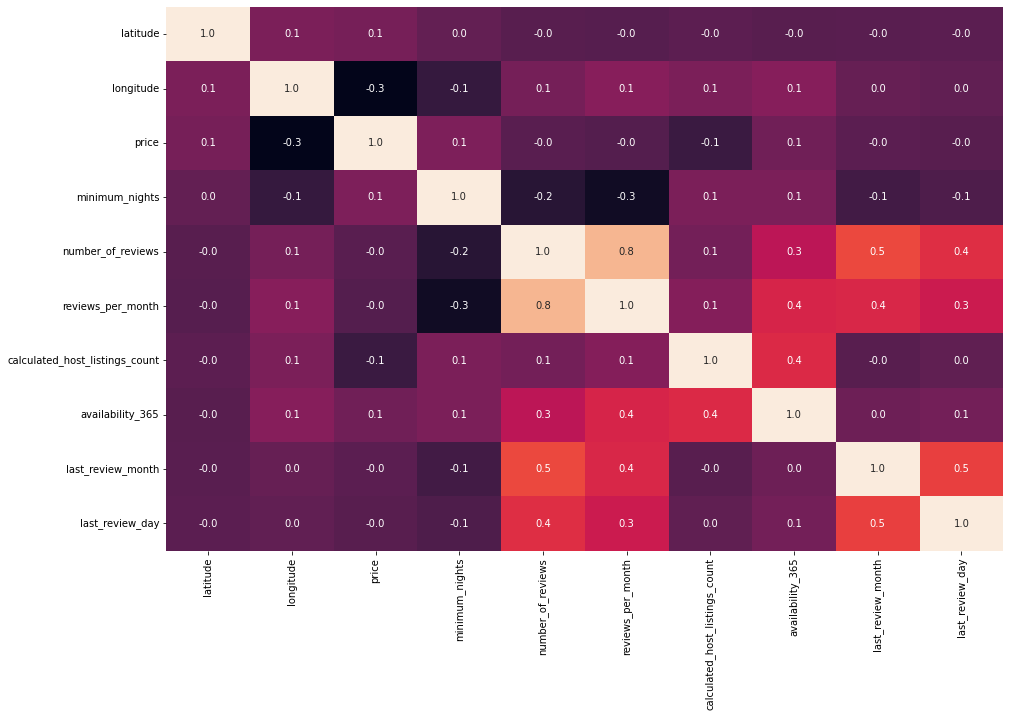

In [316]:
#Selecting relevant features for the ML task
corr = data_clean[['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'last_review_month', 'last_review_day']].corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr,cbar=False,annot=True,fmt='.1f')
plt.show()

In [295]:
#Split data
X = data_clean.drop(columns=['price'],inplace=False)
Y = data_clean['price']

#Calculate feature importance
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor()

etr.fit(X,Y)

fi_df = pd.DataFrame({"feature":X.columns,"importances":etr.feature_importances_}).sort_values(by='importances',ascending=False)

#Visualize the feature importances

fig = px.bar(fi_df,x='feature',y='importances')
fig.show()

##Splitting the dataset into Train and Test

In [317]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8,random_state=3)

#Modelling

##Bagging - Random Forest Regression

In [318]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

#Training
rfr = RandomForestRegressor()
rfr.fit(X_train,Y_train)

RandomForestRegressor()

In [319]:
#Evaluation
def metrics(model,X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test):
    # Make predictions on test data
    Y_pred = model.predict(X_test)
    # Show Metrics
    print(f"Model Score (fit) on Train data: {model.score(X_train,Y_train)}")
    print(f"Model Score (fit) on Test data: {model.score(X_test,Y_test)}")
    print(f"Mean Square Error (MSE): {mean_squared_error(Y_test,Y_pred)}")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(Y_test,Y_pred)}")
    print(f"R-squared (R^2) value: {r2_score(Y_test,Y_pred)}")
    # Plot the distribution of errors
    error = pd.DataFrame({"Error":Y_test - Y_pred})
    fig = px.histogram(error,x='Error')
    fig.show()

metrics(rfr)

Model Score (fit) on Train data: 0.9409024350192898
Model Score (fit) on Test data: 0.5675613585635892
Mean Square Error (MSE): 2009.1232035905718
Mean Absolute Error (MAE): 32.10177937493194
R-squared (R^2) value: 0.5675613585635892


##Boosting - XGBoost

In [218]:
import xgboost as xgb

#Model Training
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [219]:
#Model Evaluation
metrics(xgbr)

Model Score (fit) on Train data: 0.7044575150537463
Model Score (fit) on Test data: 0.5768395305207261
Mean Square Error (MSE): 1966.0165318461866
Mean Absolute Error (MAE): 31.715102783542928
R-squared (R^2) value: 0.5768395305207261
